In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def create_thresh(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),1000)
    flag, thresh = cv2.threshold(blur, 140, 255, cv2.THRESH_BINARY)
    return thresh

In [3]:
def erode_image(image):
    kernel = np.ones((5,5),np.uint8)
    eroded = cv2.erode(image,kernel,iterations=4)
    return eroded

In [4]:
def get_almost_square_contours(image):
    im2, contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)[1:]
    
    results = []
    
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)

        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        A = 0.39

        if w/h > 1+A or w/h < 1-A:
            pass
        elif h/w < 1-A or h/w > 1+A:
            pass
        else:     
            results.append((x,y,w,h))
            
    return results

In [5]:
def add_contours(image, contours):
    for contour in contours:
        x,y,w,h = contour
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

In [6]:
def warp_contour_from_image(image, contour):
    x,y,w,h = contour
    C = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)
    B = np.array([ [x,y],[x+w,y],[x+w,y+h],[x,y+h] ],np.float32)
    transform = cv2.getPerspectiveTransform(B,C)
    warp = cv2.warpPerspective(image,transform,(450,450))
    return warp
    

In [7]:
def create_training_images(image, contours):
    image = image.copy()    
    results = []
    
    for i, contour in enumerate(contours):
        
        warp = warp_contour_from_image(image, contour)
        cv2.imwrite('training/%s.jpg' % i , warp)
        
        results.append(warp)
        
    return results
        


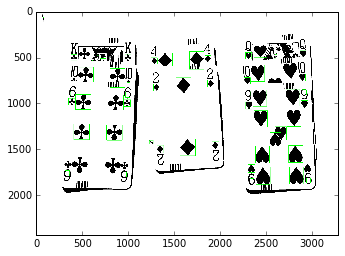

In [8]:
train_original_image = cv2.imread('images/training_1.jpg')
train_thresh = create_thresh(train_original_image)
# train_erode = erode_image(train_thresh)
train_base = train_thresh

train_almost_square_contours = get_almost_square_contours(train_base)
training_images = create_training_images(train_thresh, train_almost_square_contours)

# output = original_image.copy()
output = cv2.cvtColor(train_base, cv2.COLOR_GRAY2RGB)
add_contours(output, train_almost_square_contours)

cv2.imwrite("output.jpg", output)
plt.figure()
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

In [9]:
# These are hard-coded for the images generated above

training_labels = [
    'h', # 0
    'h',
    'h',
    'h',
    'h',
    'h',
    'h',
    'h',
    'h',
    'h',
    'd', # 10 
    None, 
    'd',
    None,
    'c', 
    'c',
    'd',
    'c',
    'c',
    'h',
    'h', # 20
    'h',
    'c',
    'c',
    'h',
    'h',
    'h',
    'h',
    'h',
    'h',
    'h', # 30
    'h',
    'd',
    'd',
    'c',
    'd',
    'c',
    'd',
    'd',
    'd',
    None, # 40
    None,
    None,
    None,
    'c', 
    'c',
    None,
    None,
    None,
    None,
    None, # 50
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None, # 60
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None, # 70
    None,
    None,
]

# training_set = zip(training_images, training_labels)

In [10]:
def imgdiff(img1,img2):
    img1 = cv2.GaussianBlur(img1,(5,5),5)
    img2 = cv2.GaussianBlur(img2,(5,5),5)    
    diff = cv2.absdiff(img1,img2)  
    diff = cv2.GaussianBlur(diff,(5,5),5)    
    flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY) 
    return np.sum(diff)

In [11]:
def guess_contour_values(image, contours, training_set):
    training_set = list(training_set)
    image = image.copy()  
    
    results = []
    
    for contour in contours[:]:
        
        warp = warp_contour_from_image(image, contour)
        r = sorted(training_set, key=lambda x:imgdiff(x[0],warp))[0]
        
        if imgdiff(r[0],warp) < 550000:
            suit = r[1]
        else:
            suit = None
        
        results.append((contour, suit))
        
    return results

In [12]:
def add_contours_with_colours(image, test_results):
    for contour, label in test_results:
        x, y, w, h = contour

        if label == 's':
            rgb = (255,0,0)
        elif label == 'h':
            rgb = (0,0,255)
        elif label == 'd':
            rgb = (0,255,0)
        elif label == 'c':
            rgb = (0,0,0)
        else:
            rgb = (255, 255, 255)

        cv2.rectangle(image,(x,y),(x+w,y+h),rgb,2)

In [13]:
test_original_image = cv2.imread('images/testing_1.jpg')
test_thresh = create_thresh(test_original_image)
# test_erode = erode_image(test_thresh)
test_base = test_thresh

test_almost_square_contours = get_almost_square_contours(test_base)

output = cv2.cvtColor(test_base, cv2.COLOR_GRAY2RGB)
add_contours(output, test_almost_square_contours)

test_results = guess_contour_values(
    test_thresh, 
    test_almost_square_contours, 
    zip(training_images, training_labels)
)



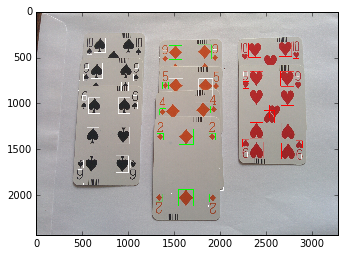

In [14]:
output = test_original_image.copy()

add_contours_with_colours(output, test_results)    

cv2.imwrite("output.jpg", output)
plt.figure
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))